In [1]:
from roboticstoolbox import Robot
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
from spatialmath import SE3
import numpy as np
import swift
import sympy

## Robot kinematics

Load URDF

In [29]:
robot = Robot.URDF('/Users/admin/Desktop/r12_kinematics/r12.urdf')
robot

ERobot: r12, 5 joints (RRRRR), geometry, collision
┌─────┬─────────────────────┬───────┬─────────────────────┬──────────────────────────────┐
│link │        link         │ joint │       parent        │     ETS: parent to link      │
├─────┼─────────────────────┼───────┼─────────────────────┼──────────────────────────────┤
│   0 │ base_link           │       │ BASE                │ SE3()                        │
│   1 │ waist_shoulder_link │     0 │ base_link           │ SE3(0, 0, 0.0925) ⊕ Rz(q0)   │
│   2 │ shoulder_elbow_link │     1 │ waist_shoulder_link │ SE3(0, 0, 0.2105) ⊕ Rx(q1)   │
│   3 │ elbow_hand_link     │     2 │ shoulder_elbow_link │ SE3(0.04, 0, 0.25) ⊕ Rx(q2)  │
│   4 │ hand_wrist_link     │     3 │ elbow_hand_link     │ SE3(-0.04, 0, 0.25) ⊕ Rx(q3) │
│   5 │ @wrist_tool_link    │     4 │ hand_wrist_link     │ SE3(0, 0, 0.02) ⊕ Rz(q4)     │
└─────┴─────────────────────┴───────┴─────────────────────┴──────────────────────────────┘

This command will open swift sim in your browser

In [11]:
robot.plot([np.pi, np.pi / 4, np.pi / 4, 0, 0])

Swift backend, t = 0.05, scene:
  r12

ETS description

In [4]:
robot.ets()

SE3(0, 0, 0.0925) ⊕ Rz(q0) ⊕ SE3(0, 0, 0.2105) ⊕ Rx(q1) ⊕ SE3(0.04, 0, 0.25) ⊕ Rx(q2) ⊕ SE3(-0.04, 0, 0.25) ⊕ Rx(q3) ⊕ SE3(0, 0, 0.02) ⊕ Rz(q4)


Forward kinematics as a $SE(3)$ matrix

In [57]:
q0, q1, q2, q3, q4 = sympy.symbols("q0 q1 q2 q3 q4", real=True)
robot.fkine([q0, q1, q2, q3, q4])

  -1.0*sin(q0)*sin(q4)*cos(q1 + q2 + q3) + 1.0*cos(q0)*cos(q4) -1.0*sin(q0)*cos(q4)*cos(q1 + q2 + q3) - 1.0*sin(q4)*cos(q0) 1.0*sin(q0)*sin(q1 + q2 + q3) 1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*sin(q0)  
  1.0*sin(q0)*cos(q4) + 1.0*sin(q4)*cos(q0)*cos(q1 + q2 + q3) -1.0*sin(q0)*sin(q4) + 1.0*cos(q0)*cos(q4)*cos(q1 + q2 + q3) -1.0*sin(q1 + q2 + q3)*cos(q0) -1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*cos(q0)  
  1.0*sin(q4)*sin(q1 + q2 + q3) 1.0*sin(q1 + q2 + q3)*cos(q4) 1.0*cos(q1 + q2 + q3) 0.25*cos(q1) + 0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3) + 0.303  
  0            0            0            1.00000000000000  


Joint limits

In [6]:
print("Joint limits:")
for i, (lower, upper) in enumerate(robot.qlim.T):
    print(f"Joint {i+1}: {np.rad2deg(lower):.1f}° to {np.rad2deg(upper):.1f}°")

Joint limits:
Joint 1: -180.0° to 180.0°
Joint 2: -180.0° to 180.0°
Joint 3: -129.5° to 129.5°
Joint 4: -119.7° to 119.7°
Joint 5: -180.0° to 180.0°


Plot workspace

Text(0.5, 0.92, 'Operational Space (Workspace)')

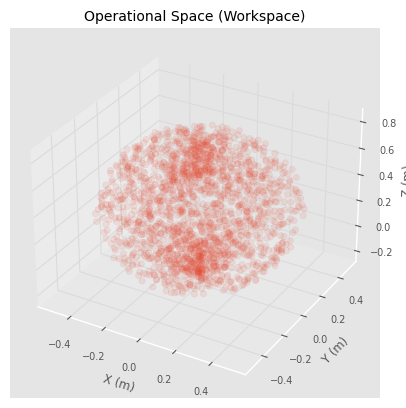

In [13]:
x_points, y_points, z_points = [], [], []
for _ in range(2000):
    q_rand = np.array([np.random.uniform(low, high) 
                       for low, high in robot.qlim.T])
    T = robot.fkine(q_rand)
    pos = T.t
    x_points.append(pos[0])
    y_points.append(pos[1])
    z_points.append(pos[2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_points, y_points, z_points, alpha=0.1)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Operational Space (Workspace)')

Solve inverse kinematics

In [35]:
robot.q = [0, 0, 0, 0, 0]
Tep = SE3.Trans(0.4, 0.1, 0.4)
sol = robot.ik_LM(Tep)
q_pickup = sol[0]
robot.fkine(q_pickup)

   1        -5.873e-08  4.709e-07  0.3999    
   5.873e-08  1         1.178e-07  0.1       
  -4.709e-07 -1.178e-07  1         0.4       
   0         0         0         1         


## Joint-state trajectory

Plot joint coordinates

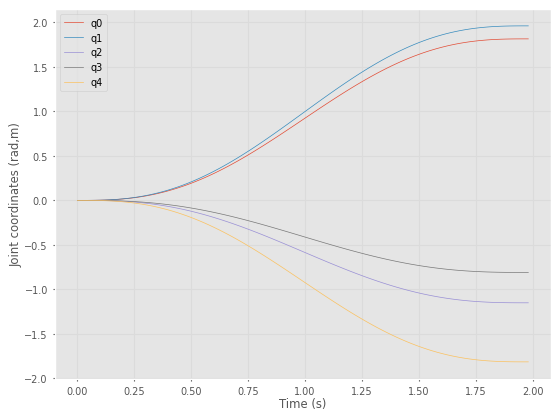

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [36]:
t = np.arange(0, 2, 0.02)
qt = rtb.jtraj(robot.q, q_pickup, t)
rtb.xplot(t, qt.q)

Plot end-effector position in Cartesian space ($x\ y\ z$)

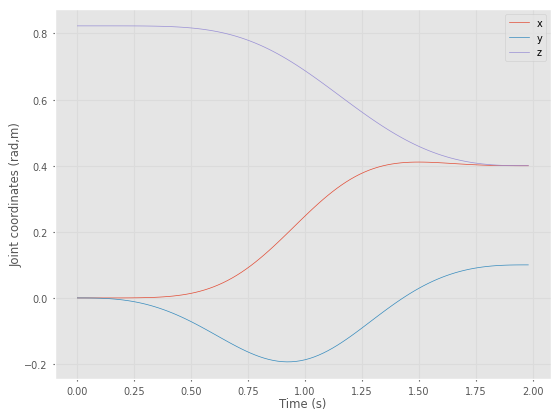

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [37]:
T = robot.fkine(qt.q)
rtb.xplot(t, T.t, labels="x y z")

Plot end-effector position in Cartesian space ($roll\ pitch\ yaw$)

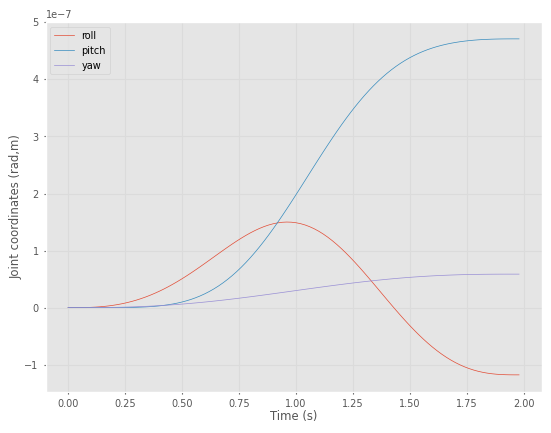

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [38]:
rtb.xplot(t, T.rpy("xyz"), labels="roll pitch yaw")

End-effector position in $xy$-plane

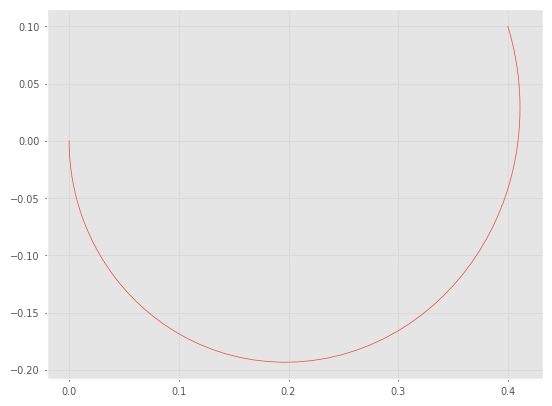

In [39]:
plt.plot(T.t[:, 0], T.t[:, 1])

## Cartesian trajectory

Plot end-effector position in Cartesian space 

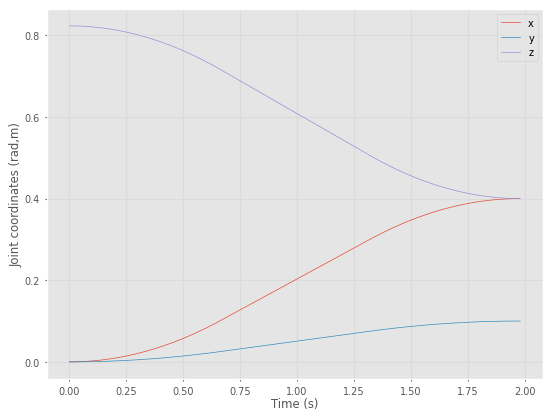

[<Axes: xlabel='Time (s)', ylabel='Joint coordinates (rad,m)'>]

In [43]:
robot.q = [0, 0, 0, 0, 0]
t = np.arange(0, 2, 0.02)
qt = rtb.ctraj(robot.fkine(robot.q),Tep, t)
rtb.xplot(t, qt.t, labels="x y z")

End-effector position in $xy$-plane

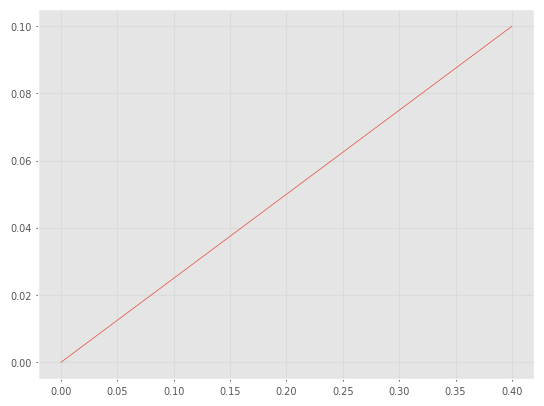

In [44]:
plt.plot(qt.t[:, 0], qt.t[:, 1])

## Manipulator Jacobian

In [60]:
q = sympy.symbols("q:5")
TE = robot.fkine(q)
p = TE.t
p

array([1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*sin(q0),
       -1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*cos(q0),
       0.25*cos(q1) + 0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3) + 0.303],
      dtype=object)

In [61]:
J = sympy.Matrix(p).jacobian(q)
J

Matrix([
[1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*cos(q0),  1.0*(0.25*cos(q1) + 0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3))*sin(q0),  1.0*(0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3))*sin(q0),  0.02*sin(q0)*cos(q1 + q2 + q3), 0],
[1.0*(0.25*sin(q1) + 0.25*sin(q1 + q2) + 0.02*sin(q1 + q2 + q3))*sin(q0), -1.0*(0.25*cos(q1) + 0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3))*cos(q0), -1.0*(0.25*cos(q1 + q2) + 0.02*cos(q1 + q2 + q3))*cos(q0), -0.02*cos(q0)*cos(q1 + q2 + q3), 0],
[                                                                      0,               -0.25*sin(q1) - 0.25*sin(q1 + q2) - 0.02*sin(q1 + q2 + q3),               -0.25*sin(q1 + q2) - 0.02*sin(q1 + q2 + q3),         -0.02*sin(q1 + q2 + q3), 0]])

In [62]:
J.shape

(3, 5)

## Jacobian singularities

In [79]:
robot.q = [0, 0, 0, 0, 0]
J = robot.jacob0(robot.q)
J

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.52, -0.27, -0.02,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  1.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  1.  ]])

In [80]:
np.linalg.matrix_rank(J)

3

In [81]:
np.linalg.cond(J)

inf

In [82]:
robot.manipulability(robot.q)

0.0